# Word2Vec (Negative Sampling)

2 things we need to add
- how to sample the negative samples
- the process of getting the negative samples

1 thing we need to change:
model

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
np.__version__, torch.__version__

('1.24.0', '1.12.1')

In [3]:
import matplotlib
matplotlib.__version__

'3.6.2'

## 1. Load data

In [4]:
#specify the sentences / corpus
#corpus is defined as a set of documents
#document is basically a bunch of sentence(s)
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple", "grape apple apple", 
          "dog cat animal", "cat dog animal", "cat animal dog", "fish dog dog"]

In [5]:
#1. tokenize
#usually you use spaCy / NLTK to tokenize (but we gonna do this later on, we gonna have spaCy)
corpus_tokenized = [sent.split(" ") for sent in corpus]
corpus_tokenized  #we called each of this as "tokens", NOT words

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['grape', 'apple', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'dog', 'animal'],
 ['cat', 'animal', 'dog'],
 ['fish', 'dog', 'dog']]

In [6]:
#2. numericalize

#2.1 get all the unique words
#we want to flatten this (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words your system know

In [7]:
#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [8]:
word2index['dog']

7

In [9]:
#add <UNK>, which is a very normal token exists in the world
vocabs.append('<UNK>') #chaky, can it be ##UNK, or UNKKKKKK, or anything

In [10]:
#now we have a way to know what is the id of <UNK>
word2index['<UNK>'] = 6  #usually <UNK> is 0

In [11]:
#create index2word dictionary
#2 min    
index2word = {v:k for k, v in word2index.items()}

index2word

{0: 'banana',
 1: 'cat',
 2: 'grape',
 3: 'fruit',
 4: 'fish',
 5: 'apple',
 6: '<UNK>',
 7: 'dog'}

In [12]:
vocabs

['banana', 'cat', 'grape', 'fruit', 'fish', 'apple', 'animal', 'dog', '<UNK>']

## 2. Prepare train data
You move the window along, and create those tuples as we said in class

In [13]:
#move along the corpus
#to fit with our corpus, we gonna use window_size = 1

skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    #for each sent ["apple", "banana", "fruit"]
    for i in range(1, len(sent) - 1): #start from 1 to second last
        center_word = sent[i]
        outside_words = [sent[i-1], sent[i+1]]  #window_size = 1
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams
        
#here we want to create (banana, apple), (banana, fruit) append to some list
        

[['banana', 'apple'],
 ['banana', 'fruit'],
 ['apple', 'banana'],
 ['apple', 'fruit'],
 ['fruit', 'banana'],
 ['fruit', 'apple'],
 ['apple', 'grape'],
 ['apple', 'apple'],
 ['cat', 'dog'],
 ['cat', 'animal'],
 ['dog', 'cat'],
 ['dog', 'animal'],
 ['animal', 'cat'],
 ['animal', 'dog'],
 ['dog', 'fish'],
 ['dog', 'dog']]

In [14]:
#let's make what we have made into a function (batch function)
#return a batches of data, e.g., =2 --> ['banana', 'apple'], ['banana', 'fruit']
#also i want these batches to be id, NOT token   --> [5, 4]

def random_batch(batch_size, corpus):
    
    skipgrams = []

    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ["apple", "banana", "fruit"]
        for i in range(1, len(sent) - 1): #start from 1 to second last
            center_word = word2index[sent[i]]
            outside_words = [word2index[sent[i-1]], word2index[sent[i+1]]]  #window_size = 1
            for o in outside_words:
                skipgrams.append([center_word, o])
                
    #only get a batch, not the entire list
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    random_inputs, random_labels = [], []   
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)
    

In [15]:
input, label = random_batch(10, corpus_tokenized)

print(f"{input.shape}")
print(f"{label=}")

(10, 1)
label=array([[3],
       [4],
       [6],
       [0],
       [0],
       [3],
       [1],
       [7],
       [1],
       [2]])


## 3. Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [16]:
#basically create a distribution of all the words you have in your vocabs

In [17]:
z = 0.001  #scaling up low frequency terms

In [18]:
#count all the occurrences of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

Counter({'apple': 5,
         'banana': 3,
         'fruit': 3,
         'grape': 1,
         'dog': 5,
         'cat': 3,
         'animal': 3,
         'fish': 1})

In [19]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

24

In [20]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    # print("vocab: ", v)
    # print("distribution: ", uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)
    
Counter(unigram_table)

Counter({'banana': 210,
         'cat': 210,
         'grape': 92,
         'fruit': 210,
         'fish': 92,
         'apple': 308,
         'animal': 210,
         'dog': 308})

In [21]:
word_count

Counter({'apple': 5,
         'banana': 3,
         'fruit': 3,
         'grape': 1,
         'dog': 5,
         'cat': 3,
         'animal': 3,
         'fish': 1})

## 4. Negative sampling

A function to get negative samples, based on the current center and outside words in the batch

In [22]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [23]:
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

### Test our negative sampling method

In [24]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenized)

input_batch, label_batch

(array([[1],
        [7]]),
 array([[6],
        [1]]))

In [25]:
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [26]:
num_neg = 5  #in the real code, we gonna use 10 (like in the paper)
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [27]:
neg_samples.shape

torch.Size([2, 5])

## 5. Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [28]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words: (batch_size, 1)
        #negative_words:  (batch_size, k)
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()


### Testing the model

In [29]:
input, label = random_batch(batch_size, corpus_tokenized)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [30]:
emb_size = 2 #usually, this can be 50, 100, or 300
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [31]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [32]:
input_tensor.shape, label_tensor.shape#, neg_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [33]:
#this should give one number
loss = model(input_tensor, label_tensor, neg_tensor)

In [34]:
loss

tensor(5.0527, grad_fn=<NegBackward0>)

## 4. Training

In [35]:
voc_size   = len(vocabs)
batch_size = 2 #why?  no reason; 
emb_size   = 2 #why?  no reason; usually 50, 100, 300, but 2 so we can plot (50 can also plot, but need PCA)
model      = SkipgramNeg(voc_size, emb_size)

optimizer  = optim.Adam(model.parameters(), lr=0.001)

In [36]:
num_epochs = 5000
#for epoch
for epoch in range(num_epochs):

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: ??")

Epoch 1000 | Loss: 0.811026 | Time: ??
Epoch 2000 | Loss: 0.354529 | Time: ??
Epoch 3000 | Loss: 0.228919 | Time: ??
Epoch 4000 | Loss: 0.064696 | Time: ??
Epoch 5000 | Loss: 0.173528 | Time: ??


## 5. Plot the embeddings

Is really the related stuff are close to each other, and vice versa?

The most fun part:  Will "banana" closer to "fruit" than "cat"?

In [37]:
vocabs

['banana', 'cat', 'grape', 'fruit', 'fish', 'apple', 'animal', 'dog', '<UNK>']

In [38]:
banana = torch.LongTensor([word2index['banana']])
banana

tensor([0])

In [39]:
banana_center_embed = model.embedding_center_word(banana)
banana_outisde_embed = model.embedding_outside_word(banana)

banana_embed = (banana_center_embed + banana_outisde_embed) / 2
banana_embed

tensor([[ 1.9417, -3.6350]], grad_fn=<DivBackward0>)

In [40]:
def get_embed(word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()


In [41]:
#find embedding of fruit, cat
print(get_embed('fruit'))
print(get_embed('cat'))

print(get_embed('chaky'))

(1.365776538848877, -2.8166699409484863)
(-0.8624510765075684, 4.279304027557373)
(0.4309408664703369, 3.8758819103240967)


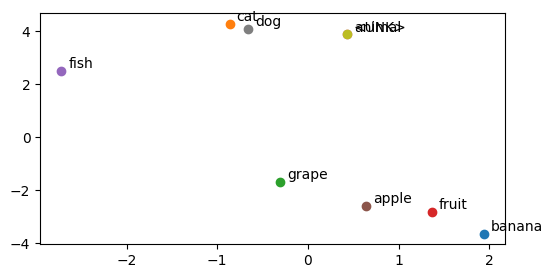

In [42]:
#help me plot fruit cat banana on matplotlib
plt.figure(figsize=(6,3))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 6. Cosine similarity

How do (from scratch) calculate cosine similarity?